### Please use the following link to try out the OMERO Python language bindings
https://docs.openmicroscopy.org/latest/omero/developers/Python.html

### Import Packages required to connect to OMERO

In [3]:
from omero.gateway import BlitzGateway

### Create a connection to an OMERO server

In [4]:
import config

HOST = 'omero.mri.cnrs.fr'
PORT = 4064
USERNAME = config.USERNAME
PASSWORD = config.PASSWORD
conn = BlitzGateway(USERNAME, PASSWORD, host=HOST, port=PORT)
conn.connect()

# Using secure connection.
# By default, once we have logged in, data transfer is not encrypted
# (faster)
# To use a secured connection, call setSecure(True):
conn.setSecure(True)

### User info

In [3]:
user = conn.getUser()
print "Current user:"
print "  ID:", user.getId()
print "  Username:", user.getName()
print "  Full Name:", user.getFullName()
print "Member of:"
for g in conn.getGroupsMemberOf():
    print "  ID:", g.getName(), " Name:", g.getId()
group = conn.getGroupFromContext()
print "Current group: ", group.getName()

Current user:
  ID: 859
  Username: cedrichk
  Full Name: CEDRIC HASSEN-KHODJA
Member of:
  ID: default  Name: 103
  ID: MRI-COMMUN  Name: 254
Current group:  default


### Read Data method

In [6]:
def print_obj(obj, indent=0):
    """
    Helper method to display info about OMERO objects.
    Not all objects will have a "name" or owner field.
    """
    print """%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName())

### Get Projects/Datasets/Images of the current User

In [110]:
my_exp_id = conn.getUser().getId()
default_group_id = conn.getEventContext().groupId
for project in conn.getObjects("Project", opts={'owner': my_exp_id,
                                            'group': default_group_id,
                                            'order_by': 'lower(obj.name)',
                                            'limit': 5, 'offset': 0}):
    print_obj(project)
    # We can get Datasets with listChildren, since we have the Project already.
    # Or conn.getObjects("Dataset", opts={'project', id}) if we have Project ID
    for dataset in project.listChildren():
        print_obj(dataset, 2)
        for image in dataset.listChildren():
            print_obj(image, 4)

Project:2232  Name:"cellprofiler" (owner=cedrichk)
  Dataset:3985  Name:"cellprofiler" (owner=cedrichk)
    Image:441563  Name:"AS_09125_050116030001_D03f00d0.tiff" (owner=cedrichk)
    Image:441564  Name:"AS_09125_050116030001_D03f00d1.tiff" (owner=cedrichk)
    Image:441565  Name:"AS_09125_050116030001_D03f00d2.tiff" (owner=cedrichk)


### Images metadata

In [6]:
# Pixels and Channels will be loaded automatically as needed
ids = [441563, 441564, 441565]
for images in ids:
    image = conn.getObject("Image", images)
    print image.getName()
    print " X:", image.getSizeX()
    print " Y:", image.getSizeY()
    print " Z:", image.getSizeZ()
    print " C:", image.getSizeC()
    print " T:", image.getSizeT()
# List Channels (loads the Rendering settings to get channel colors)
for channel in image.getChannels():
    print 'Channel:', channel.getLabel(),
    print 'Color:', channel.getColor().getRGB()

AS_09125_050116030001_D03f00d0.tiff
 X: 512
 Y: 512
 Z: 1
 C: 1
 T: 1
AS_09125_050116030001_D03f00d1.tiff
 X: 512
 Y: 512
 Z: 1
 C: 1
 T: 1
AS_09125_050116030001_D03f00d2.tiff
 X: 512
 Y: 512
 Z: 1
 C: 1
 T: 1
Channel: 0 Color: (128, 128, 128)


### Render image

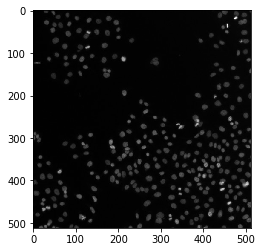

In [12]:
import matplotlib.pyplot as plt

z = 0
t = 0
image = conn.getObject("Image", 441563)
renderedImage = image.renderImage(z, t)
plt.imshow(renderedImage)

### Merge images channels

<_ImageWrapper id=441563>


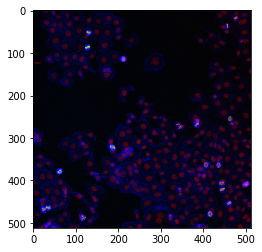

In [121]:
from skimage import color
from skimage import img_as_float

image_d0 = conn.getObject("Image", 441563)
image_d1 = conn.getObject("Image", 441564)
image_d2 = conn.getObject("Image", 441565)


rendered_image_d0 = image_d0.renderImage(0, 0)
rendered_image_d1 = image_d1.renderImage(0, 0)
rendered_image_d2 = image_d2.renderImage(0, 0)

d0 = color.gray2rgb(img_as_float(rendered_image_d0))
rgb_d0 = color.gray2rgb(d0)
red_multiplier = [1, 0, 0]
red_d0 = rgb_d0 * red_multiplier

d1 = color.gray2rgb(img_as_float(rendered_image_d1))
rgb_d1 = color.gray2rgb(d1)
green_multiplier = [0, 1, 0]
green_d1 = rgb_d1 * green_multiplier

d2 = color.gray2rgb(img_as_float(rendered_image_d2))
rgb_d2 = color.gray2rgb(d2)
blue_multiplier = [0, 0, 1]
blue_d2 = rgb_d2 * blue_multiplier
new_image = red_d0+green_d1+blue_d2
plt.imshow(new_image)
plt.imsave('./ExampleHuman/images/image_merged.png', new_image)

### get Metadata from local image 

In [8]:
from PIL import Image
import tifffile as tf

i = Image.open('./ExampleHuman/images/image_merged.png')
i.save('./ExampleHuman/images/image_merged.tif')

ni = tf.imread('./ExampleHuman/images/image_merged.tif')

print ni.shape
print ni.dtype

(512, 512, 4)
uint8


### Write image to omero server 

In [25]:
from numpy import array, int8

#my_exp_id = conn.getUser().getId()
#default_group_id = conn.getEventContext().groupId
#for project in conn.getObjects("Project"):
#    print_obj(project)
    # We can get Datasets with listChildren, since we have the Project already.
    # Or conn.getObjects("Dataset", opts={'project', id}) if we have Project ID
#    for dataset in project.listChildren():
#        dataset.g
  
datasets = conn.getObjects("Dataset", opts={'Project': 2232})

for dataset in datasets:
    size_x, size_y, size_z, size_c, size_t = 512, 512, 1, 4, 1
    plane1 = array(ni[:,:,0])
    plane2 = array(ni[:,:,1])
    plane3 = array(ni[:,:,2])
    plane4 = array(ni[:,:,3])
    planes = [plane1, plane2, plane3, plane4]

    def plane_gen():
        for p in planes:
            yield p

    desc = "Image imported from a local image"
    i = conn.createImageFromNumpySeq(
    plane_gen(), "merge image", size_z, size_c, size_t, description=desc, dataset=print_obj(dataset,2))

    print 'Created new Image:%s Name:"%s"' % (i.getId(), i.getName())

  Dataset:3985  Name:"cellprofiler" (owner=cedrichk)
Created new Image:598527 Name:"merge image"


<br>
#### When you are completely finished running the notebook close the connection to OMERO server

In [ ]:
conn.close()